In [ ]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
from matplotlib import gridspec
import ipywidgets
import pybop
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

go = pybop.plot.PlotlyManager().go
pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"


In [2]:
params_LT = pb.ParameterValues("Chen2020")

# Load data in the appropriate format
path= os.getcwd()

neg_ocp_M50LT_data = pb.parameters.process_1D_data(
    "LG_M50LT_Uneg.csv", path=path
)
pos_ocp_M50LT_data = pb.parameters.process_1D_data(
    "LG_M50LT_Upos.csv", path=path
)



def neg_ocp_M50LT(sto):
    name, (x, y) = neg_ocp_M50LT_data
    return pb.Interpolant(x, y, sto, name=name, interpolator="cubic")


def pos_ocp_M50LT(sto):
    name, (x, y) = pos_ocp_M50LT_data
    return pb.Interpolant(x, y, sto, name=name, interpolator="cubic")


In [3]:
pb.set_logging_level("NOTICE")

model = pb.lithium_ion.DFN()

# Update the model parameters with the OCP functions
params_LT.update(
    {
        "Negative electrode OCP [V]": neg_ocp_M50LT,
        #"Positive electrode OCP [V]": pos_ocp_M50LT,
    },
    check_already_exists=False,
)

#Simple discharge experiment
experiment = pb.Experiment(
    [
        (
            "Charge at 1C until 4.2 V",
            "Discharge at C/10 until 2.5 V",
        )
    ]
)

# run pybamm model (LT)
sim = pb.Simulation(
    model=model, 
    experiment = experiment,
    parameter_values=params_LT,
    solver=model.default_solver
    )
solution = sim.solve(calc_esoh=True)

# run pybamm model (Chen2020)
sim_Chen2020 = pb.Simulation(
    model=model, 
    experiment = experiment,
    parameter_values=pb.ParameterValues("Chen2020"),
    solver=model.default_solver
    )

solution = sim.solve(calc_esoh=True)
solution_Chen2020 = sim_Chen2020.solve(calc_esoh=True)

C:\Users\frw21\AppData\Local\Temp\ipykernel_14980\1048324082.py:29: UserWarning: The default solver changed to IDAKLUSolver after the v25.4.0. release. You can swap back to the previous default by using `pybamm.CasadiSolver()` instead.
  solver=model.default_solver
2025-07-18 13:49:04.397 - [NOTICE] logger.func(7): Cycle 1/1 (47.900 us elapsed) --------------------
2025-07-18 13:49:04.398 - [NOTICE] logger.func(7): Cycle 1/1, step 1/2: Charge at 1C until 4.2 V
2025-07-18 13:49:04.590 - [NOTICE] logger.func(7): Cycle 1/1, step 2/2: Discharge at C/10 until 2.5 V
2025-07-18 13:49:04.805 - [NOTICE] logger.func(7): Finish experiment simulation, took 415.796 ms
2025-07-18 13:49:04.805 - [NOTICE] logger.func(7): Cycle 1/1 (14.300 us elapsed) --------------------
2025-07-18 13:49:04.805 - [NOTICE] logger.func(7): Cycle 1/1, step 1/2: Charge at 1C until 4.2 V
2025-07-18 13:49:04.822 - [NOTICE] logger.func(7): Cycle 1/1, step 2/2: Discharge at C/10 until 2.5 V
2025-07-18 13:49:04.883 - [NOTICE] 

In [7]:
model.variables.search("Charge")

Results for 'Charge': ['Discharge capacity [A.h]', 'Discharge energy [W.h]']


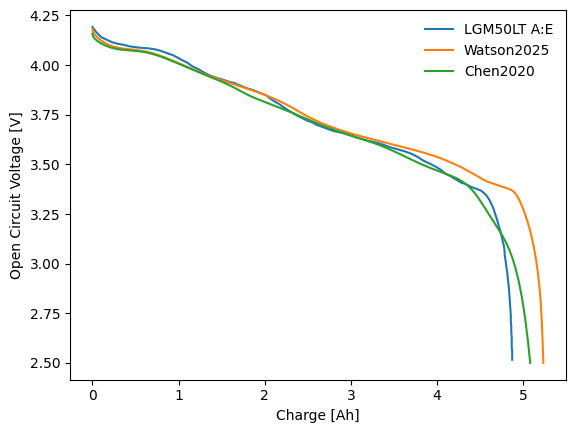

In [ ]:
# Load data in the appropriate format
path= os.getcwd()

OCV_M50LT_data = pb.parameters.process_1D_data(
    "plot-data.csv", path=path
)

# Flips the y-axis and starts the discharge at x=0
OCV_M50LT_Discharge_data = 4.86631016-np.squeeze(OCV_M50LT_data[1][0])

plt.plot(OCV_M50LT_Discharge_data, OCV_M50LT_data[1][1])
plt.xlabel("Charge [Ah]")
plt.ylabel("Open Circuit Voltage [V]")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))


OCV_Watson2025 = solution["Terminal voltage [V]"]    
t_Watson2025 = solution["Time [s]"].entries
C_Watson2025 = solution["Discharge capacity [A.h]"].entries
plt.plot(t_Watson2025, OCV_Watson2025(t_Watson2025))

OCV_Chen2020 = solution_Chen2020["Terminal voltage [V]"]    
t_Chen2020 = solution_Chen2020["Time [s]"].entries
C_Chen2020 = solution_Chen2020["Discharge capacity [A.h]"].entries
plt.plot(t_Chen2020, OCV_Chen2020(t_Chen2020))

plt.legend(
    [
        "LGM50LT A:E",
        "Watson2025",
        "Chen2020",
    ], loc='best', frameon=False
)



Let's fix the random seed in order to generate consistent output during development, although this does not need to be done in practice.

In [ ]:
np.random.seed(8)

In [ ]:
from scipy.interpolate import interp1d
from sklearn.metrics import root_mean_squared_error
import math

# Interpolate OCV_M50LT_Discharge_data to Watson2025 and Chen2020
OCV_M50LT_Discharge_data_interp = interp1d(OCV_M50LT_Discharge_data, OCV_M50LT_data[1][1], bounds_error=False, fill_value="extrapolate")
OCV_M50LT_Discharge_on_Watson2025 = OCV_M50LT_Discharge_data_interp(C_Watson2025)
OCV_M50LT_Discharge_on_Chen2020 = OCV_M50LT_Discharge_data_interp(C_Chen2020)

### Creating a Dataset

The dataset for optimisation is composed of time, current, and the noisy voltage data:

In [ ]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
        "Voltage [V]": corrupt_values,
    }
)